In [2]:
import pickle
import matplotlib.pyplot as plt
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
from IPython.display import VimeoVideo
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.pipeline import make_pipeline

# Prepare Data

## Import

In [3]:
# importing .csv data
df = pd.read_csv("bankrupt_data.csv")
print(df.shape)
df.head()

(9792, 65)


,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64,bankrupt
0,0.159290,0.46240,0.07773,1.1683,-44.853,0.467020,0.189480,0.82895,1.1223,0.38330,...,0.108990,0.41557,0.89101,0.001422,7.7928,4.9914,119.810,3.0465,3.0560,0
1,-0.127430,0.46243,0.26917,1.7517,7.597,0.000925,-0.127430,1.16250,1.2944,0.53757,...,-0.089372,-0.23704,1.06250,0.150410,5.4327,3.4629,100.970,3.6150,3.4725,0
2,0.070488,0.23570,0.52781,3.2393,125.680,0.163670,0.086895,2.87180,1.0574,0.67689,...,0.054286,0.10413,0.94571,0.000000,7.1070,3.3808,76.076,4.7978,4.7818,0
3,0.136760,0.40538,0.31543,1.8705,19.115,0.504970,0.136760,1.45390,1.1144,0.58938,...,0.102630,0.23203,0.89737,0.073024,6.1384,4.2241,88.299,4.1337,4.6484,0
4,-0.110080,0.69793,0.18878,1.2713,-15.344,0.000000,-0.110080,0.43282,1.7350,0.30207,...,0.439880,-0.36440,0.57153,0.000000,18.8010,2.7925,146.390,2.4934,15.0360,0


## Splitting data

In [4]:
# splitting features from target
target = "bankrupt"
X = df.drop(columns=target)
y = df[target]

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (9792, 64)
y shape: (9792,)


In [5]:
# creating train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (7833, 64)
y_train shape: (7833,)
X_test shape: (1959, 64)
y_test shape: (1959,)


In [6]:
# let us proceed with the oversampling technique, since it delivered the best accuracy score on previous studies
over_sampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over = over_sampler.fit_resample(X_train, y_train)
print("X_train_over shape:", X_train_over.shape)
X_train_over.head()

X_train_over shape: (14842, 64)


,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_55,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64
0,0.069548,0.69574,0.055553,1.0897,-27.2160,-0.264400,0.069113,0.36634,1.0355,0.25488,...,580.85,0.034314,0.272870,0.96569,0.30020,10.9890,6.4865,85.355,4.2762,8.1421
1,-0.084151,0.62034,0.114540,1.2505,-5.9921,0.000000,-0.084151,0.61202,1.6597,0.37966,...,557.14,-0.121260,-0.221650,1.04600,0.00000,11.5100,7.3495,100.560,3.6295,3.8759
2,0.081425,0.10163,0.424230,5.1741,124.5500,0.297150,0.101460,8.52550,1.1220,0.86647,...,18200.00,0.108710,0.093974,0.89129,0.00000,5.5087,3.9838,41.429,8.8102,1.8885
3,0.011690,0.80729,-0.216890,0.6474,-124.9500,-0.037361,0.011781,0.23871,1.0410,0.19271,...,-3420.70,0.039353,0.060664,0.96065,0.99729,17.1860,2.5425,259.880,1.4045,1.4356
4,0.000917,0.33013,0.591420,2.8261,-30.7370,0.000000,0.000917,2.02910,1.4833,0.66987,...,3355.10,0.270390,0.001369,0.73336,0.00000,2.2321,6.9965,79.698,4.5798,17.5120


# Building model

## Baseline

In [7]:
# Let us first define our baseline as the Accuracy score
# considering that we classify every firm as not bankrupt
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 4))

Baseline Accuracy: 0.9474


## Iterating

**Ensemble models** work by building multiple models on random subsets of the same data, and then comparing their predictions to make a final prediction. Since we used a decision tree in the last study (data_exploring.ipynb), we're going to create an ensemble of trees here. This type of model is called a **random forest**.  

Let us create a pipeline for our workflow.

In [8]:
# creating a pipeline 
clf = make_pipeline(
    SimpleImputer(),
    RandomForestClassifier(random_state=42)
)
print(clf)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])


The default setting for the number of trees in our forest (n_estimators) is 100, resulting in the fitting of 100 trees when training this classifier. Although this may prolong the training process, it can potentially improve the classifier's performance.  
To optimize our model's performance, we need to tune its hyperparameters. However, without a validation set, this can be challenging. One solution is to employ cross-validation. Before delving into hyperparameter tuning, let's explore how cross-validation operates with the aforementioned classifier.

In [9]:
# performing cross-validation on the train set oversampled, considering 5 folds
cv_acc_scores = cross_val_score(clf, X_train_over, y_train_over, cv=5, n_jobs=-1)
print(cv_acc_scores)

[0.99831593 0.99562142 0.9962938  0.99663073 0.99696765]


Let's proceed with the hyperparameter tunning of our model

In [10]:
# defining parameters for our GridSearch algorithm
params = {
    "simpleimputer__strategy": ["mean", "median"],
    "randomforestclassifier__n_estimators": range(25, 100, 25),
    "randomforestclassifier__max_depth": range(10, 50, 10)
}
params

{'simpleimputer__strategy': ['mean', 'median'],
 'randomforestclassifier__n_estimators': range(25, 100, 25),
 'randomforestclassifier__max_depth': range(10, 50, 10)}

In [12]:
# GridSearch our model, using our params variation previously defined
model = GridSearchCV(
    clf,
    param_grid=params,
    cv=5,
    n_jobs=-1,
    verbose=1
)
model

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(10, 50, 10),
                         'randomforestclassifier__n_estimators': range(25, 100, 25),
                         'simpleimputer__strategy': ['mean', 'median']},
             verbose=1)

In [13]:
# Train model
model.fit(X_train_over, y_train_over)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(10, 50, 10),
                         'randomforestclassifier__n_estimators': range(25, 100, 25),
                         'simpleimputer__strategy': ['mean', 'median']},
             verbose=1)

We have tested four different max_depth values, three n_estimator values, and two imputation strategies, amounting to 24 forests. Furthermore, we have performed 120 fits, considering that each forest has been trained using a five-fold cross-validation technique. Each forest is made up of a minimum of 25 and a maximum of 75 trees, equating to at least 3,000 trees. Therefore, it is a computationally demanding task. Having examined all the models, let us proceed to investigate the outcomes.

In [17]:
# exploring GridSearch results
cv_results = pd.DataFrame(model.cv_results_)
cv_results.sort_values("rank_test_score").head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__max_depth,param_randomforestclassifier__n_estimators,param_simpleimputer__strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
20,8.882375,0.170612,0.086008,0.012773,40,50,mean,"{'randomforestclassifier__max_depth': 40, 'ran...",0.997979,0.995285,0.997305,0.996968,0.996631,0.996833,0.000894,1
14,8.927606,0.099433,0.085716,0.008266,30,50,mean,"{'randomforestclassifier__max_depth': 30, 'ran...",0.997979,0.994948,0.996631,0.997305,0.996631,0.996699,0.001008,2
16,13.289515,0.214551,0.118400,0.006831,30,75,mean,"{'randomforestclassifier__max_depth': 30, 'ran...",0.997979,0.995621,0.995957,0.996968,0.996968,0.996699,0.000836,3
22,13.054422,0.210054,0.121324,0.019576,40,75,mean,"{'randomforestclassifier__max_depth': 40, 'ran...",0.997979,0.995958,0.995957,0.996294,0.996968,0.996631,0.000768,4
23,10.398008,1.825815,0.067633,0.015021,40,75,median,"{'randomforestclassifier__max_depth': 40, 'ran...",0.996295,0.995285,0.995957,0.997305,0.997305,0.996429,0.000785,5
21,9.089098,0.171746,0.087335,0.014540,40,50,median,"{'randomforestclassifier__max_depth': 40, 'ran...",0.996295,0.994611,0.995957,0.997642,0.997305,0.996362,0.001073,6
12,4.400859,0.114687,0.046625,0.003349,30,25,mean,"{'randomforestclassifier__max_depth': 30, 'ran...",0.997305,0.995285,0.995620,0.997978,0.995620,0.996362,0.001074,7
17,13.865807,0.433851,0.122146,0.008459,30,75,median,"{'randomforestclassifier__max_depth': 30, 'ran...",0.996295,0.994948,0.995957,0.996968,0.996968,0.996227,0.000750,8
18,4.404830,0.042025,0.051097,0.010163,40,25,mean,"{'randomforestclassifier__max_depth': 40, 'ran...",0.996969,0.994948,0.995957,0.997642,0.995283,0.996160,0.001013,9
15,9.158244,0.089445,0.089261,0.009833,30,50,median,"{'randomforestclassifier__max_depth': 30, 'ran...",0.995958,0.994611,0.995620,0.996968,0.996631,0.995958,0.000825,10


In [16]:
# extract best hyperparameters
model.best_params_

{'randomforestclassifier__max_depth': 40,
 'randomforestclassifier__n_estimators': 50,
 'simpleimputer__strategy': 'mean'}

# Evaluate

In [18]:
acc_train = model.score(X_train_over, y_train_over)
acc_test = model.score(X_test, y_test)

print("Training Accuracy:", round(acc_train, 4))
print("Test Accuracy:", round(acc_test, 4))

Training Accuracy: 1.0
Test Accuracy: 0.9546


Barely beat our baseline: 0.9546 (model) - 0.9474 (baseline)

Let's investigate our Confusion matrix:

In [20]:
# double checking True labels count
y_test.value_counts()

bankrupt
0    1856
1     103
Name: count, dtype: int64

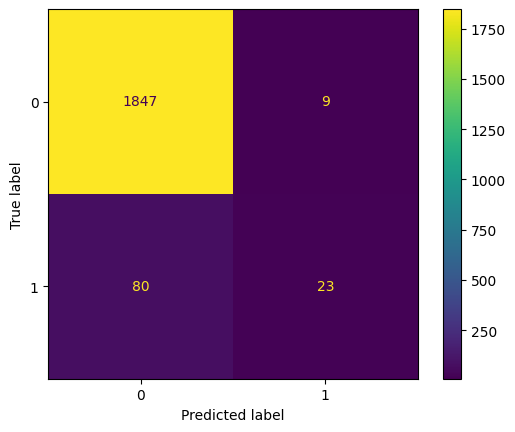

In [21]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test);

Recall and Precision metrics for our minority class (bankrupt companies):

Let's remember how they are calculated:  
Recall = True Positives / (True Positives + False Negatives)  
Precision measures the proportion of positive predictions made by the model that are actually positive. It is calculated as:  
Precision = True Positives / (True Positives + False Positives)

In [22]:
print("Recall    = ", f"{(23/(23+80)*100):.2f}%")
print("Precision = ", f"{(39/(39+9)*100):.2f}%")

Recall    =  22.33%
Precision =  81.25%


|         Model         |  Recall   | Precision |
|-----------------------|-----------|-----------|
| Decision tree model            | 37.86%    | 35.78%    |
| Rancom Forest model          | 22.33%    | 81.25%    |



# Communicating our results

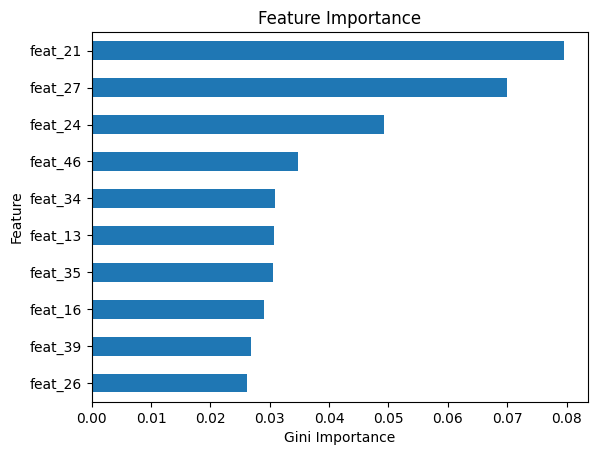

In [23]:
# Get feature names from training data
features = X_train_over.columns
# Extract importances from model
importances = model.best_estimator_.named_steps["randomforestclassifier"].feature_importances_
# Create a series with feature names and importances
feat_imp = pd.Series(importances, index=features).sort_values()
# Plot 10 most important features
feat_imp.tail(10).plot(kind="barh")
plt.xlabel("Gini Importance")
plt.ylabel("Feature")
plt.title("Feature Importance");

In [26]:
# Save model
with open("randfor", "wb") as file:
    pickle.dump(model, file)

In [27]:
# loading our model to check if it was correctly saved
with open("randfor", "rb") as f:
    loaded_model = pickle.load(f)

print(loaded_model)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(10, 50, 10),
                         'randomforestclassifier__n_estimators': range(25, 100, 25),
                         'simpleimputer__strategy': ['mean', 'median']},
             verbose=1)


In [28]:
# testing loaded model
loaded_model.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [30]:
# double checking number of predicted bankrupt companies (should be 32, 23 TP + 9 FP)
loaded_model.predict(X_test).sum()

32